# Anomaly detection with an Autoencoder

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, metrics, model_selection

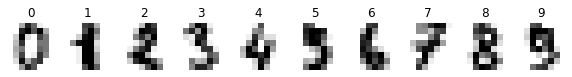

In [2]:
digits = datasets.load_digits()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title('%i' % label)

In [3]:
target = digits.target
data = digits.images

print("min value: {}".format(np.amin(data)))
print("max value: {}".format(np.amax(data)))
print("shape: {}".format(np.shape(data)))

min value: 0.0
max value: 16.0
shape: (1797, 8, 8)


train samples: 898
test samples 899


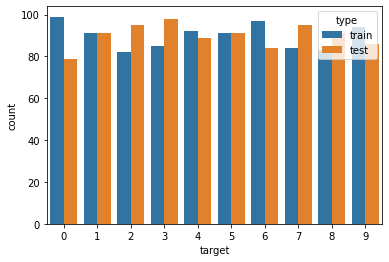

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data, target, test_size=0.5)


X_train = X_train.astype('float32') / 16.
X_test = X_test.astype('float32') / 16.


df_train = pd.DataFrame(y_train, columns=['target'])
df_train['type'] = 'train'

df_test = pd.DataFrame(y_test, columns=['target'])
df_test['type'] = 'test'

df_set = df_train.append(df_test)

_ = sns.countplot(x='target', hue='type', data=df_set)     

print('train samples:', len(X_train))
print('test samples', len(X_test))

In [5]:
class Autoencoder(tf.keras.models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(64, activation='sigmoid'),
            tf.keras.layers.Reshape((8, 8))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()


autoencoder.compile(optimizer='adam', loss='mse')




In [6]:
%%time
history = autoencoder.fit(X_train, X_train,
            epochs=100,
            validation_split = 0.2,
            validation_data=(X_test, X_test),
            verbose=0)


CPU times: user 7.3 s, sys: 1.15 s, total: 8.45 s
Wall time: 6.2 s


In [7]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.030729,0.032242,95
96,0.030723,0.032170,96
97,0.030645,0.032152,97
98,0.030580,0.032278,98
99,0.030637,0.032423,99


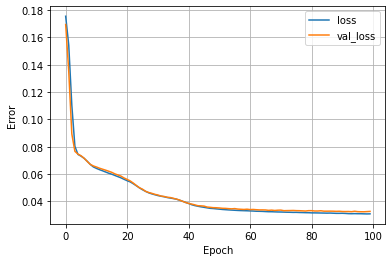

In [8]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

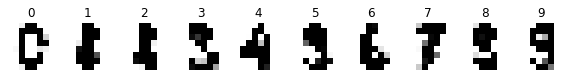

In [9]:
reconstructions = autoencoder.predict(digits.images)


fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image, label in zip(axes, reconstructions, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title('%i' % label)

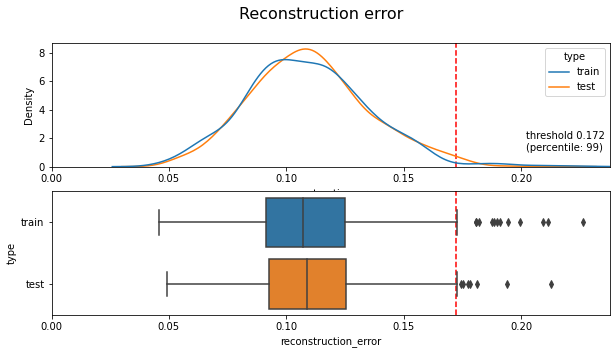

In [10]:
reconstruction_error_train = np.mean(tf.keras.losses.mae(autoencoder.predict(X_train), X_train), axis=-1)
reconstruction_error_test = np.mean(tf.keras.losses.mae(autoencoder.predict(X_test), X_test), axis=-1)

df_train = pd.DataFrame(reconstruction_error_train, columns=['reconstruction_error'])
df_train['type'] = 'train'

df_test = pd.DataFrame(reconstruction_error_test, columns=['reconstruction_error'])
df_test['type'] = 'test'

df_set = df_train.append(df_test)


fig, axs = plt.subplots(nrows=2, figsize=(10, 5))
fig.suptitle('Reconstruction error', fontsize=16)

p_threshold = 99
threshold = np.percentile(reconstruction_error_test, p_threshold)

x_max = np.max(reconstruction_error_test) + np.std(reconstruction_error_test)


axs[0].axvline(threshold, color='r', ls='--')
axs[0].set(xlim=(0, x_max))

axs[0].text(0.85, 0.2, 'threshold {:.3f}\n(percentile: {})'.format(threshold, p_threshold), 
            horizontalalignment='left', verticalalignment='center', transform=axs[0].transAxes)


axs[1].axvline(threshold, color='r', ls='--')
axs[1].set(xlim=(0, x_max))


_ = sns.kdeplot(data=df_set, x='reconstruction_error' ,hue='type', ax=axs[0])
_ = sns.boxplot(data=df_set, x='reconstruction_error', y='type', orient='h', ax=axs[1])



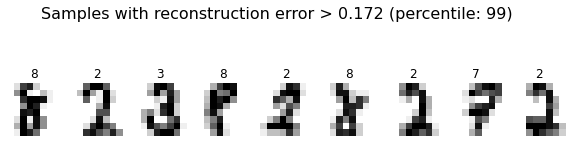

In [11]:
anomalies_index = np.argwhere(reconstruction_error_test > threshold).flatten()

anomalies_x = np.array(X_test)[anomalies_index] 
anomalies_y = np.array(y_test)[anomalies_index] 


fig, axes = plt.subplots(nrows=1, ncols=len(anomalies_x), figsize=(10, 3))
fig.suptitle('Samples with reconstruction error > {:.3f} (percentile: {})'.format(threshold, p_threshold), fontsize=16)

for ax, image, label, in zip(axes, anomalies_x, anomalies_y):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title('%i' % label)


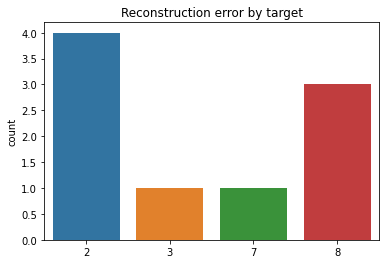

In [12]:
_ = sns.countplot(x=anomalies_y).set_title('Reconstruction error by target')     

In [13]:
flipped_images = np.array([np.transpose(x) for x in digits.images[0:10]])
flipped_images = flipped_images / 16.
flipped_images

reconstruction_error_flipped_images = np.mean(tf.keras.losses.mae(autoencoder.predict(flipped_images), flipped_images), axis=-1) 
is_anomaly = reconstruction_error_flipped_images > threshold

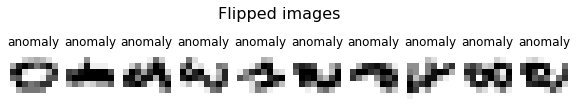

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=len(flipped_images), figsize=(10, 2))
fig.suptitle('Flipped images'.format(threshold, p_threshold), fontsize=16)
for ax, image, anomaly in zip(axes, flipped_images, is_anomaly):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    if anomaly:
        ax.set_title('anomaly')

In [15]:
pd.DataFrame(reconstruction_error_flipped_images, columns=['reconstruction_error'])

,reconstruction_error
0,0.261416
1,0.327757
2,0.335030
3,0.343261
4,0.253397
5,0.314342
6,0.324002
7,0.315494
8,0.355156
9,0.316725
